<a href="https://colab.research.google.com/github/Igli333/data-science/blob/main/Mini_Project_3_DS_Igli_Balla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project 3

### Igli Balla

#### Needed packages installation

In [ ]:
!pip install networkx
!pip install scipy
!pip install plotly

#### Importing all required libraries

In [ ]:
import os
import csv
import sys
import json
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import numpy as np
import matplotlib.pyplot as plt
import scipy
import plotly.graph_objects as go
import pandas as pd

#### Loading the dataset
##### (Please place all the CSV files inside a folder called data or modify this block)

In [ ]:
pd.options.mode.copy_on_write = True  # to remove warnings throughout the notebook

artists_df = pd.read_csv('data/artists.csv')
institutions_df = pd.read_csv('data/institutions.csv')
schools_df = pd.read_csv('data/schools.csv')
relationships_df = pd.read_csv('data/relationships.csv')

#### Function needed to process the data for insertion into the graph later on

In [ ]:
def explode_column(source_df, column_to_explode, final_columns):
    df = source_df.dropna(subset=[column_to_explode])
    df[column_to_explode] = df[column_to_explode].str.split(',')

    return df.explode(column_to_explode).reset_index(drop=True)[final_columns]

### EDA

#### Distribution of Artists Nationalities

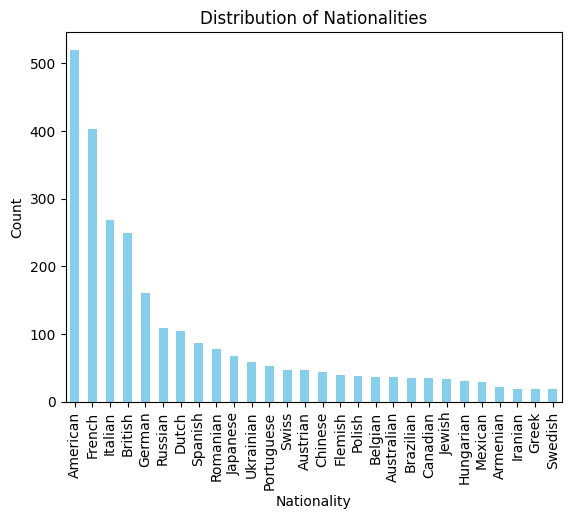

In [ ]:
nationality_count = artists_df['nation'].value_counts()
nationality_count = nationality_count[nationality_count > 15]
nationality_count.plot(kind='bar', color='skyblue')
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.title('Distribution of Nationalities')
plt.show()

#### Distribution of artistic movements

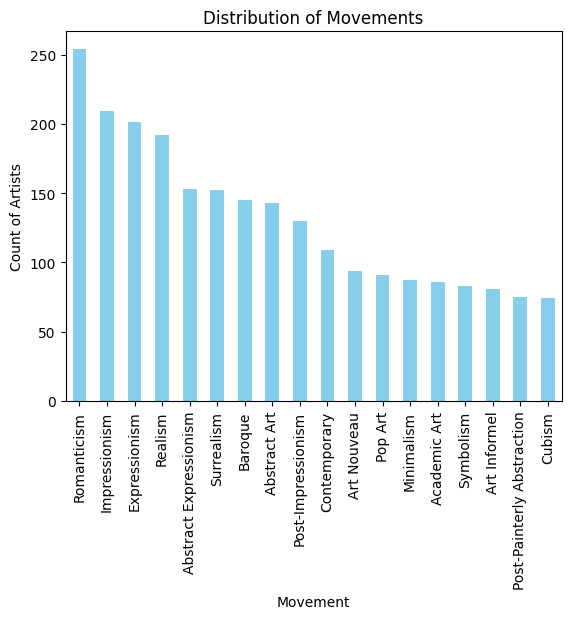

In [ ]:
movements_df = explode_column(relationships_df, 'movements', ['artistUrl', 'movements'])
movements_count = movements_df['movements'].value_counts()
movements_count = movements_count[movements_count > 70]

movements_count.plot(kind='bar', color='skyblue')
plt.xlabel('Movement')
plt.ylabel('Count of Artists')
plt.title('Distribution of Movements')
plt.show()

#### Distribution of artists by number of artworks

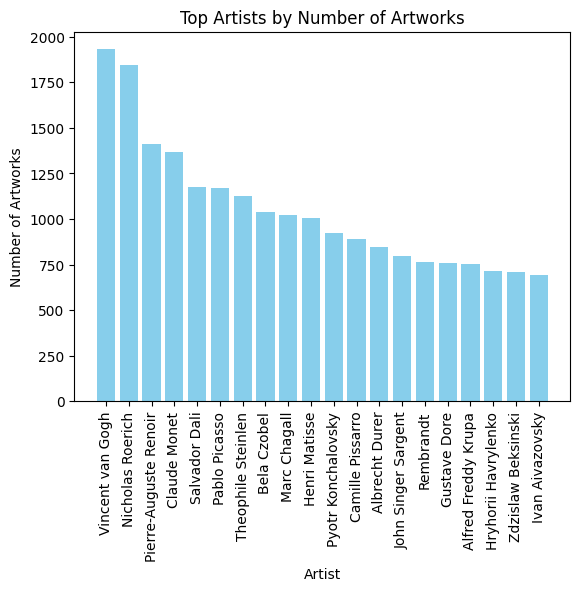

In [ ]:
top_artists_artworks_df = artists_df[['title', 'artistUrl', 'totalWorksTitle']]
top_artists_artworks_df['totalWorksTitle_count'] = top_artists_artworks_df['totalWorksTitle'].str.extract(r'(\d+)').astype(int)

top_artists_artworks_df_plot = top_artists_artworks_df.nlargest(20, 'totalWorksTitle_count')

plt.bar(top_artists_artworks_df_plot['title'], top_artists_artworks_df_plot['totalWorksTitle_count'], color='skyblue')
plt.xlabel('Artist')
plt.ylabel('Number of Artworks')
plt.title('Top Artists by Number of Artworks')
plt.xticks(rotation=90)
plt.show()

#### Distribution of artworks in artistic movements

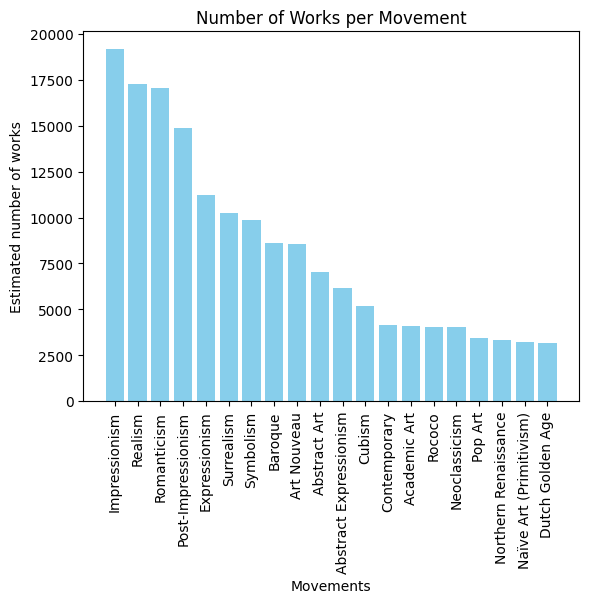

In [ ]:
merged_df = pd.merge(top_artists_artworks_df, movements_df, on='artistUrl')
merged_df = merged_df[['title', 'totalWorksTitle_count', 'movements']]

merged_df = merged_df.groupby('movements')['totalWorksTitle_count'].sum().reset_index()
merged_df = merged_df.nlargest(20, 'totalWorksTitle_count')
plt.bar(merged_df['movements'], merged_df['totalWorksTitle_count'], color='skyblue')
plt.xlabel('Movements')
plt.ylabel('Estimated number of works')
plt.title('Number of Works per Movement')
plt.xticks(rotation=90)
plt.show()

#### Distribution of schools by number of artists

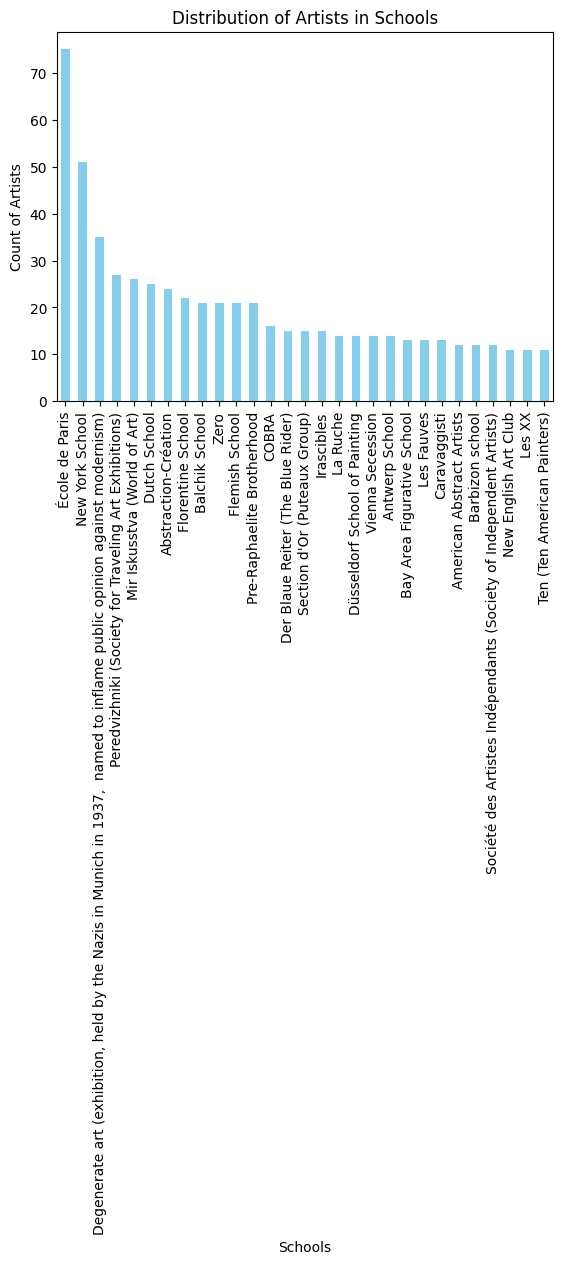

In [ ]:
artists_schools_df = pd.merge(artists_df, relationships_df, on='artistUrl')
artists_schools_df = explode_column(artists_schools_df, 'school', ['artistUrl', 'school'])
artists_schools_df = pd.merge(artists_schools_df, schools_df, left_on='school', right_on='url')

artists_schools_df = artists_schools_df['title'].value_counts()
artists_schools_df = artists_schools_df[artists_schools_df > 10]
artists_schools_df.plot(kind='bar', color='skyblue')
plt.xlabel('Schools')
plt.ylabel('Count of Artists')
plt.title('Distribution of Artists in Schools')
plt.show()

#### Distribution of instiutions by number of artists

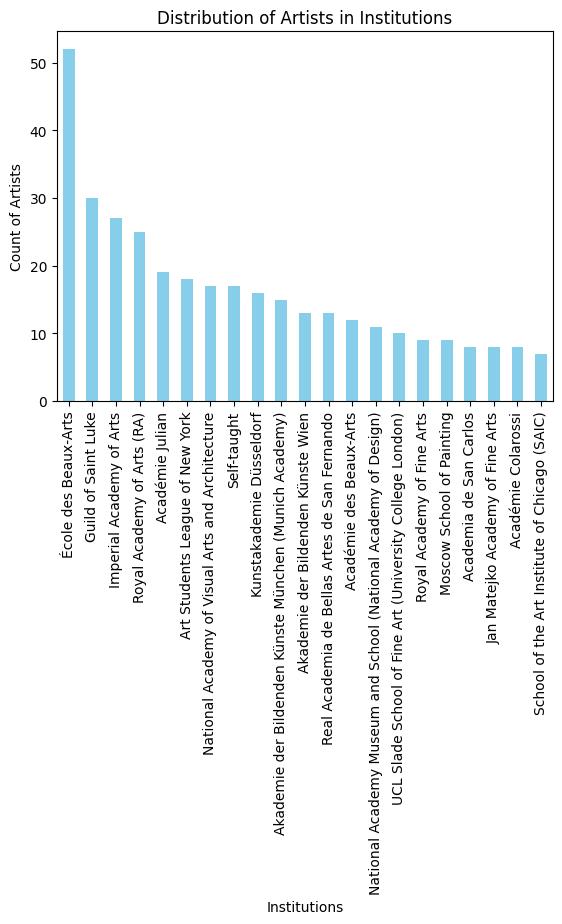

In [ ]:
artists_institutions_df = pd.merge(artists_df, relationships_df, on='artistUrl')
artists_institutions_df = artists_institutions_df.dropna(subset=['institution'])
artists_institutions_df = pd.merge(artists_institutions_df, institutions_df, left_on='institution', right_on='url')

artists_institutions_df = artists_institutions_df['title_y'].value_counts()
artists_institutions_df = artists_institutions_df[artists_institutions_df > 6]
artists_institutions_df.plot(kind='bar', color='skyblue')
plt.xlabel('Institutions')
plt.ylabel('Count of Artists')
plt.title('Distribution of Artists in Institutions')
plt.show()

### Creating the network

In [ ]:
G = nx.Graph()

for _, row in artists_df.iterrows():
    G.add_node(row['artistUrl'], type='artist', **row.to_dict())

for _, row in schools_df.iterrows():
    G.add_node(row['url'], type='school', **row.to_dict())

for _, row in institutions_df.iterrows():
    G.add_node(row['url'], type='institution', **row.to_dict())

movements = set(movements_df['movements'].to_list())
for mov in movements:
    G.add_node(mov, type='movement')

for nation in set(artists_df['nation'].unique()):
    G.add_node(nation, type='nation')

friendships_df = explode_column(relationships_df, 'friends', ['artistUrl', 'friends'])
for _, row in friendships_df.iterrows():
    G.add_edge(row['artistUrl'], row['friends'], relationship='friendship')

influenced_by_df = explode_column(relationships_df, 'influenced_by',['artistUrl', 'influenced_by'])
for _, row in influenced_by_df.iterrows():
    G.add_edge(row['artistUrl'], row['influenced_by'], relationship='influenced_by')

influenced_on_df = explode_column(relationships_df, 'influenced_on', ['artistUrl', 'influenced_on'])
for _, row in influenced_on_df.iterrows():
    G.add_edge(row['artistUrl'], row['influenced_on'], relationship='influenced_on')

artist_of_school_df = explode_column(relationships_df, 'school', ['artistUrl', 'school'])
for _, row in artist_of_school_df.iterrows():
    G.add_edge(row['artistUrl'], row['school'], relationship='part_of_school')

artist_of_institution_df = explode_column(relationships_df, 'institution', ['artistUrl', 'institution'])
for _, row in artist_of_institution_df.iterrows():
    G.add_edge(row['artistUrl'], row['institution'], relationship='part_of_institution')

artist_of_movement_df = explode_column(relationships_df, 'movements', ['artistUrl', 'movements'])
for _, row in artist_of_movement_df.iterrows():
    G.add_edge(row['artistUrl'], row['movements'], relationship='part_of_movement')

for _, row in artists_df.iterrows():
    G.add_edge(row['artistUrl'], row['nation'], relationship='nationality')

print(G)

Graph with 3769 nodes and 11249 edges


### Average Degree of the Network

In [ ]:
degree_sequence = [d for n, d in G.degree()]
avg_degree = sum(degree_sequence) / len(degree_sequence)
print("Average degree:", avg_degree)

Average degree: 5.9692226054656405


### Function for interactive visualization

In [ ]:
def visualize_graph_interactively(G, title):
    pos = nx.spring_layout(G)

    edge_x = []
    edge_y = []

    node_degrees = dict(G.degree())
    sizes = [node_degrees[node]/5 for node in G.nodes()]
    labels = list(G.nodes())

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=labels,
        textposition="top center",
        marker=dict(
            showscale=True,
            colorscale='Earth',
            reversescale=True,
            color=[],
            size=sizes,
            colorbar=dict(
                thickness=15,
                title=dict(
                    text='Node Connections',
                    side='right'
                ),
                xanchor='left',
            ),
            line_width=2
        ))

    node_adj = []
    node_text = []
    for node, adj in enumerate(G.adjacency()):
        node_adj.append(len(adj[1]))

    for node, attrs in G.nodes(data=True):
        if attrs.get("type") == "artist":
            node_text.append(str(attrs.get("title")) + '(' + str(G.degree(node)) + ')')
        else:
            node_text.append(str(node) + '(' + str(G.degree(node)) + ')')

    node_trace.marker.color = node_adj
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=dict(
                            text=title,
                            font=dict(
                                size=16
                            )
                        ),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

### Interactive Visualization of the Entire Network

In [ ]:
visualize_graph_interactively(G, 'Full Network of Artists Dataset')

### The 30 nodes with highest degrees

In [ ]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

for d in sorted(degree_dict.items(), key=itemgetter(1), reverse=True)[:30]:
    print(d)

('American', 520)
('French', 402)
('Italian', 269)
('Romanticism', 254)
('British', 249)
('Impressionism', 209)
('Expressionism', 201)
('Realism', 192)
('German', 160)
('Abstract Expressionism', 153)
('Surrealism', 152)
('Baroque', 145)
('Abstract Art', 143)
('Post-Impressionism', 130)
('Contemporary', 109)
('Russian', 108)
('Dutch', 105)
('Art Nouveau', 94)
('Pop Art', 91)
('Minimalism', 87)
('Spanish', 87)
('Academic Art', 86)
('Symbolism', 83)
('/en/artists-by-art-institution/cole-des-beaux-arts', 81)
('Art Informel', 81)
('Romanian', 78)
('/en/artists-by-painting-school/cole-de-paris', 75)
('Post-Painterly Abstraction', 75)
('Cubism', 74)
('Conceptual Art', 67)


### The 30 nodes with highest betweenes centrality

In [ ]:
betweenness_dict = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_dict, 'betweenness')

for b in sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)[:30]:
    print(b)

('American', 0.1886974672523277)
('French', 0.12627824423114628)
('Italian', 0.101522034870136)
('Expressionism', 0.08159042912237978)
('Romanticism', 0.07824608845719501)
('British', 0.06940347938827493)
('Impressionism', 0.06915825620891304)
('Realism', 0.05410382155791137)
('Surrealism', 0.04968536320634795)
('German', 0.04661329612398437)
('Abstract Art', 0.04383427812159043)
('Contemporary', 0.043481000715832184)
('Post-Impressionism', 0.03318737890249139)
('Baroque', 0.029582676823103993)
('Abstract Expressionism', 0.02912752955603661)
('Japanese', 0.02826367060932568)
('Dutch', 0.023866937585090526)
('Chinese', 0.023684902968005524)
('Pop Art', 0.023361402353412913)
('Art Nouveau', 0.0211316742070159)
('Spanish', 0.01993087926458686)
('Russian', 0.01930644415925606)
('Conceptual Art', 0.018165193654477975)
('Minimalism', 0.01807785697896379)
('Symbolism', 0.01749080562045036)
('Cubism', 0.01659052140819275)
('Art Informel', 0.01461208207384101)
('/en/pablo-picasso', 0.0143626231

### The 30 nodes with highest eigenvector centrality

In [ ]:
eigenvector_dict = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

for b in sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)[:30]:
    print(b)

('American', 0.5850837785736327)
('French', 0.16925421943477956)
('Abstract Expressionism', 0.15563927239547395)
('Impressionism', 0.10011133173058923)
('Abstract Art', 0.0942206974320886)
('Romanticism', 0.08991508417865925)
('/en/artists-by-painting-school/new-york-school', 0.07371625316896252)
('/en/jackson-pollock', 0.07305014784499021)
('/en/artists-by-art-institution/art-students-league', 0.06746640348374502)
('Post-Painterly Abstraction', 0.0666265700854467)
('Realism', 0.06501458212709044)
('Expressionism', 0.0601291010878674)
('British', 0.05414531268540675)
('Minimalism', 0.052704243083090345)
('/en/willem-de-kooning', 0.052451178624738234)
('/en/mark-rothko', 0.051687223778881144)
('/en/cy-twombly', 0.05102676861616318)
('/en/ad-reinhardt', 0.049311581939275435)
('/en/helen-frankenthaler', 0.0486544651777253)
('/en/barnett-newman', 0.048304897961351845)
('Surrealism', 0.04802831560807666)
('/en/lee-krasner', 0.04751473152282722)
('Pop Art', 0.04738610905594911)
('/en/edward-

### All communities in the graph by the Louvain Community Detection Algorithm

In [ ]:
communities = nx.community.louvain_communities(G, seed=123)

for i,c in enumerate(sorted(communities, key=len, reverse=True)):
    if len(c) > 2:
        print('Class '+str(i)+':', list(c))

Class 0: ['/en/dan-christensen', '/en/ronald-davis', '/en/george-segal', '/en/william-james-glackens', '/en/morris-graves', '/en/christopher-wilmarth', '/en/lynd-ward', '/en/gary-wragg', '/en/leon-berkowitz', '/en/charles-alston', '/en/helena-almeida', '/en/marjorie-strider', '/en/taro-yamamoto', '/en/grant-wood', '/en/pat-lipsky', '/en/leroy-neiman', 'Feminist Art', '/en/phil-sims', '/en/artists-by-painting-school/washington-color-school', '/en/jane-frank', '/en/ben-shahn', '/en/douglas-abdell', '/en/julio-gonzalez', '/en/ralph-goings', '/en/artists-by-painting-school/stieglitz-group', '/en/morris-louis', '/en/john-mclaughlin', '/en/martin-barre', '/en/jacob-kassay', '/en/charles-e-burchfield', '/en/erin-hanson', '/en/melissa-meyer', '/en/kishio-suga', '/en/hubertine-heijermans', '/en/paul-neagu', '/en/isa-genzken', '/en/mark-tobey', '/en/john-stuart-ingle', '/en/richard-artschwager', '/en/konrad-klapheck', '/en/peter-halley', '/en/lorna-simpson', '/en/lee-bontecou', '/en/james-lee-by

### Visualizing the 5 largest communities

<ipython-input-19-e467b1f58c0f>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



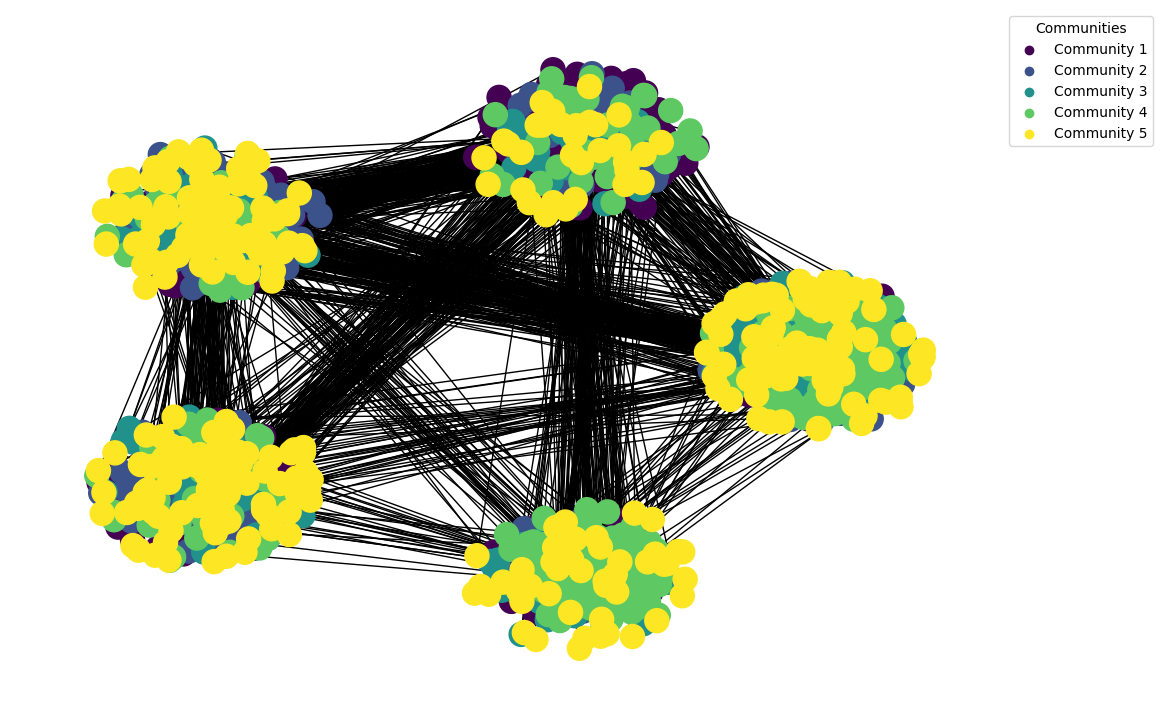

In [ ]:
communities = sorted(communities, key=len, reverse=True)[:5]

color_map = plt.cm.get_cmap('viridis', len(communities))
node_colors = {}
community_labels = []
for i, community in enumerate(communities):
    community_color = color_map(i)
    for node in community:
        node_colors[node] = community_color
    community_labels.append(f"Community {i + 1}")

pos = {}

for i, community in enumerate(communities):
    angle = 2 * np.pi * i / len(communities)
    shift = np.array([np.cos(angle), np.sin(angle)]) * 3

    subgraph = G.subgraph(community)
    sub_pos = nx.spring_layout(subgraph, k=0.3, seed=42)

    for node in community:
        pos[node] = sub_pos[node] + shift

nodes_to_plot = [node for community in communities for node in community]
colors = [node_colors[node] for node in nodes_to_plot]

plt.figure(figsize=(10, 7))
nx.draw(
    G.subgraph(nodes_to_plot), pos=pos,
    node_color=colors, node_size=300,
)

for i, label in enumerate(community_labels):
    plt.scatter([], [], color=color_map(i), label=label)
plt.legend(title="Communities", loc="upper right", bbox_to_anchor=(1.15, 1))

plt.show()

### Interactive visualization of the largest connected network

In [ ]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

visualize_graph_interactively(G0, "Biggest connected network")

### Highest betweenness centrality nodes by type

In [ ]:
max_centrality_by_type = {}

for node, centrality in betweenness_dict.items():
    node_type = G.nodes[node].get("type")
    if node_type:
        if node_type not in max_centrality_by_type:
            max_centrality_by_type[node_type] = (node, centrality)
        else:
            if centrality > max_centrality_by_type[node_type][1]:
                max_centrality_by_type[node_type] = (node, centrality)

for node_type, (node, centrality) in max_centrality_by_type.items():
    print(f"The node with the highest betweenness centrality in '{node_type}' is '{node}' with centrality: {centrality:.4f}")

The node with the highest betweenness centrality in 'artist' is '/en/pablo-picasso' with centrality: 0.0144
The node with the highest betweenness centrality in 'school' is '/en/artists-by-painting-school/cole-de-paris' with centrality: 0.0061
The node with the highest betweenness centrality in 'institution' is '/en/artists-by-art-institution/cole-des-beaux-arts' with centrality: 0.0094
The node with the highest betweenness centrality in 'movement' is 'Expressionism' with centrality: 0.0816
The node with the highest betweenness centrality in 'nation' is 'American' with centrality: 0.1887


### Highest eigenvector centrality nodes by type

In [ ]:
max_centrality_by_type = {}

for node, centrality in eigenvector_dict.items():
    node_type = G.nodes[node].get("type")
    if node_type:
        if node_type not in max_centrality_by_type:
            max_centrality_by_type[node_type] = (node, centrality)
        else:
            if centrality > max_centrality_by_type[node_type][1]:
                max_centrality_by_type[node_type] = (node, centrality)

for node_type, (node, centrality) in max_centrality_by_type.items():
    print(f"The node with the highest eigenvector centrality in '{node_type}' is '{node}' with centrality: {centrality:.4f}")

The node with the highest eigenvector centrality in 'artist' is '/en/jackson-pollock' with centrality: 0.0731
The node with the highest eigenvector centrality in 'school' is '/en/artists-by-painting-school/new-york-school' with centrality: 0.0737
The node with the highest eigenvector centrality in 'institution' is '/en/artists-by-art-institution/art-students-league' with centrality: 0.0675
The node with the highest eigenvector centrality in 'movement' is 'Abstract Expressionism' with centrality: 0.1556
The node with the highest eigenvector centrality in 'nation' is 'American' with centrality: 0.5851


### Artists of highest betweeness centrality

In [ ]:
artists_betweenness = {}

for node, centrality in betweenness_dict.items():
    if G.nodes[node].get("type") == "artist":
      artists_betweenness[node] = centrality

sorted_artists_betweenness = sorted(artists_betweenness.items(), key=itemgetter(1), reverse=True)
for b in sorted_artists_betweenness[:5]:
    print(b)

('/en/pablo-picasso', 0.014362623184557305)
('/en/fujishima-takeji', 0.010707869463862877)
('/en/orthodox-icons', 0.009540666057219205)
('/en/chang-dai-chien', 0.009212481390822773)
('/en/el-greco', 0.008387612212368514)


### Artists of highest eigenvector centrality

In [ ]:
artists_eigenvector = {}

for node, centrality in eigenvector_dict.items():
    if G.nodes[node].get("type") == "artist":
      artists_eigenvector[node] = centrality

sorted_artists_eigenvector = sorted(artists_eigenvector.items(), key=itemgetter(1), reverse=True)
for b in sorted_artists_eigenvector[:5]:
    print(b)

('/en/jackson-pollock', 0.07305014784499021)
('/en/willem-de-kooning', 0.052451178624738234)
('/en/mark-rothko', 0.051687223778881144)
('/en/cy-twombly', 0.05102676861616318)
('/en/ad-reinhardt', 0.049311581939275435)


### Artists of highest degree centrality

In [ ]:
artists_degree = {}

for node, degree in degree_dict.items():
    if G.nodes[node].get("type") == "artist":
      artists_degree[node] = degree

sorted_artists_degree = sorted(artists_degree.items(), key=itemgetter(1), reverse=True)
for b in sorted_artists_degree[:5]:
    print(b)

('/en/pablo-picasso', 56)
('/en/jackson-pollock', 35)
('/en/paul-gauguin', 33)
('/en/paul-cezanne', 32)
('/en/wassily-kandinsky', 31)
